### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import sys
import h5py
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from IPython.display import clear_output

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import HDF5Matrix
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras import regularizers

# Modify notebook settings
%matplotlib inline

Using TensorFlow backend.


### Create paths to data folders and files

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save the path to the folder that contains
# the interim data sets for modeling:
# /data/interim
interim_data_dir = os.path.join(proj_root,
                                "data",
                                "interim")

# Save path to the folder for the
# spectrogram arrays
spectrogram_arrays_path = os.path.join(interim_data_dir,
                                       "spectrogram_arrays")

# Full path for test_hdf5_path
test_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_test.hdf5")

# Full path for train_hdf5_path
train_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_train.hdf5")

# Save the path to the models folder
models_dir = os.path.join(proj_root,
                          "models")

# Full path for my_model.hdf5
model_path = os.path.join(models_dir, 
                          "my_model.hdf5")

# Save the path to the models/log folder
models_log_dir = os.path.join(models_dir,
                              "log")

# log_figure file_name
fig_file_name = "log_figure"

# Save the path to the log_figure
log_fig_path = os.path.join(models_log_dir, 
                            fig_file_name)

# log_dataframe.csv file_name
log_file_name = "log_dataframe.csv"

# Save the path to the log_figure
log_file_path = os.path.join(models_log_dir,
                             log_file_name)

# Save the path to the models/checkpoints folder
models_checkpoints_dir = os.path.join(models_dir,
                                      "checkpoints")


In [3]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

## Create objects for X_train, y_train, X_test, & y_test

In [4]:
X_train = HDF5Matrix(train_hdf5_path, 
                     'spectrogram_arrays_X_train')

y_train = HDF5Matrix(train_hdf5_path, 
                     'spectrogram_arrays_y_train')

X_test = HDF5Matrix(test_hdf5_path, 
                     'spectrogram_arrays_X_test')

y_test = HDF5Matrix(test_hdf5_path, 
                     'spectrogram_arrays_y_test')


In [5]:
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(86100, 96, 173, 1)
(1374, 96, 173, 1)
(86100, 1)
(1374, 1)
(86100, 10)
(1374, 10)


# Model...

In [7]:
#log_fig_path = log_fig_path

class User_Defined_Callback(Callback):
    def on_train_begin(self, logs={}):
#        self.i = 0
        self.i = 1
        self.x = []
        self.accuracy = []
        self.val_accuracy = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()
        
        self.logs = []
        
        self.df_log = pd.DataFrame()
        self.df_log.to_csv(log_file_path)

    def on_epoch_end(self, epoch, logs={}):
        
        # Update lists
        self.logs.append(logs)
        self.x.append(self.i)
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        # save log dataframe
        self.df_log = pd.DataFrame({'epoch_x': self.x,
                               'accuracy' : self.accuracy,
                               'val_accuracy' : self.val_accuracy,
                               'losses' : self.losses,
                               'val_losses' : self.val_losses,
                               'fig' : self.fig,
                               'logs' : self.logs})
        
        self.df_log.to_csv(log_file_path)

        
        # Create summary plots of Loss vs Epoch and Accuracy vs Epoch
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.axes.set_xlabel('Epoch')
        ax1.axes.set_ylabel('Loss Function')   
        ax1.axes.set_title('Loss vs Epoch')  
        ax1.legend()

        ax2.plot(self.x, self.accuracy, label="acc")
        ax2.plot(self.x, self.val_accuracy, label="val_acc")
        ax2.axes.set_xlabel('Epoch')
        ax2.axes.set_ylabel('Accuracy')   
        ax2.axes.set_title('Accuracy vs Epoch')  
        ax2.legend()

        plt.tight_layout()
        
        plt.savefig(log_fig_path, dpi=300)
        plt.show()
        
        
user_defined_callback = User_Defined_Callback()

In [8]:

# Checkpoint file names
checkpoint_file_name="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

# Save the path to the models/checkpoints folder
models_checkpoints_path = os.path.join(models_dir,
                                       checkpoint_file_name)

checkpoint = ModelCheckpoint(models_checkpoints_path, 
                             monitor='val_acc', verbose=0, 
                             save_best_only=True, mode='max')


In [9]:
# Define the callbacks_list
callbacks_list = [checkpoint, user_defined_callback]

In [ ]:
# For reproducibility
np.random.seed(42)

# Add BatchNormalization() layers

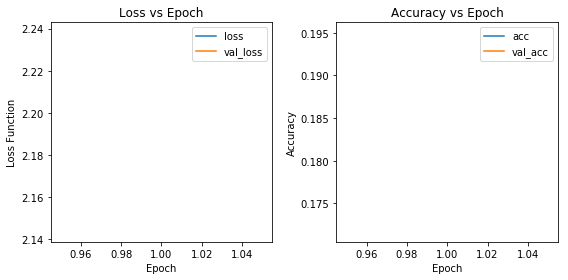

86100/86100 [==============================] - 2393s - loss: 2.2382 - acc: 0.1717 - val_loss: 2.1434 - val_acc: 0.1951
Epoch 2/50
61400/86100 [====================>.........] - ETA: 712s - loss: 2.0781 - acc: 0.2605

In [ ]:

# 7. Define model architecture
model = Sequential()

# Input Layer
model.add(Activation(None, input_shape=(96, 173, 1)))
model.add(BatchNormalization())

# Convolution Layer 1
model.add(Convolution2D(24, (5, 5), activation='relu', 
                        input_shape=(96, 173, 1)))
model.add(MaxPooling2D(pool_size=(4,2)))
#model.add(BatchNormalization())

# Convolution Layer 2
model.add(Convolution2D(48, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,2)))
#model.add(BatchNormalization())

# Convolution Layer 3
model.add(Convolution2D(48, (5, 5), 
                        padding='same',
                        activation='relu'))
#model.add(BatchNormalization())

# Dense Layer 
model.add(Flatten())
model.add(Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.001), 
                activity_regularizer=regularizers.l2(0.001)))

# Softmax Layer 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax',
                kernel_regularizer=regularizers.l2(0.001), 
                activity_regularizer=regularizers.l2(0.001)))


# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=100,
          epochs=50, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=(X_test, Y_test),
          shuffle="batch")

# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)

#...
print('test score:', score[1])

In [ ]:
model.save(model_path)  # creates a HDF5 file 'my_model.hdf5'